In [ ]:
#Standard Libraries
import numpy as np
import pandas as pd
import re
import string
from os import listdir
from pathlib import Path

# Visualization and Plotting Images
import matplotlib.pyplot as plt

# Image Processing
from PIL import Image

# Machine Learning Metrics
from sklearn.metrics import accuracy_score, auc, f1_score, precision_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score
from sklearn.model_selection import KFold

# Deep Learning with Tensorflow
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [4]:
#Uploading Data into Model from this directory structure

path_train = 'Data/histopathologic-cancer-detection/train/'
path_test = 'Data/histopathologic-cancer-detection/test/'

images_train = [f for f in listdir(path_train)]
images_test= [f for f in listdir(path_test)]

In [5]:
print('Train Images:', len(images_train))
print('Test Images:', len(images_test))
print('Split: %2.f' %(len(images_test)/(len(images_test)+len(images_train))*100),'%')

Train Images: 220025
Test Images: 57458
Split: 21 %


TIFF (96, 96) RGB


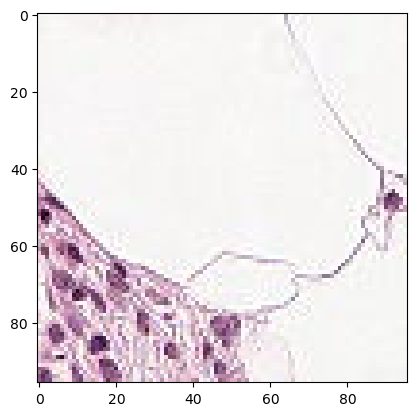

In [6]:
# View the first image in the data set
im = Image.open('Data/histopathologic-cancer-detection/train/f38a6374c348f90b587e046aac6079959adf3835.tif')
print(im.format, im.size, im.mode)
plt.imshow(im)

In [7]:
# read in the train_labels.csv
train_labels = pd.read_csv('Data/histopathologic-cancer-detection/train_labels.csv')
train_labels['path'] = train_labels['id'] + '.tif'
train_labels

,id,label,path
0,f38a6374c348f90b587e046aac6079959adf3835,0,f38a6374c348f90b587e046aac6079959adf3835.tif
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif
2,755db6279dae599ebb4d39a9123cce439965282d,0,755db6279dae599ebb4d39a9123cce439965282d.tif
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif
4,068aba587a4950175d04c680d38943fd488d6a9d,0,068aba587a4950175d04c680d38943fd488d6a9d.tif
...,...,...,...
220020,53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6,0,53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6.tif
220021,d4b854fe38b07fe2831ad73892b3cec877689576,1,d4b854fe38b07fe2831ad73892b3cec877689576.tif
220022,3d046cead1a2a5cbe00b2b4847cfb7ba7cf5fe75,0,3d046cead1a2a5cbe00b2b4847cfb7ba7cf5fe75.tif
220023,f129691c13433f66e1e0671ff1fe80944816f5a2,0,f129691c13433f66e1e0671ff1fe80944816f5a2.tif


In [8]:
print('Training Label Size:', len(train_labels['id']))
print('Missing Labels:', len(train_labels[train_labels['label'].isna()==True]))
print('Bad Labels:', len(train_labels[(train_labels['label']>1)|(train_labels['label']<0)]))
# There are no missing or bad labels

Training Label Size: 220025
Missing Labels: 0
Bad Labels: 0


([<matplotlib.patches.Wedge at 0x20270295340>,
 [Text(-0.32334109228524116, 1.051404079333815, '0'),
  Text(0.3233409938456856, -1.0514041096071884, '1')],
 [Text(-0.17636786851922245, 0.5734931341820809, '59.5%'),
  Text(0.1763678148249194, -0.57349315069483, '40.5%')])

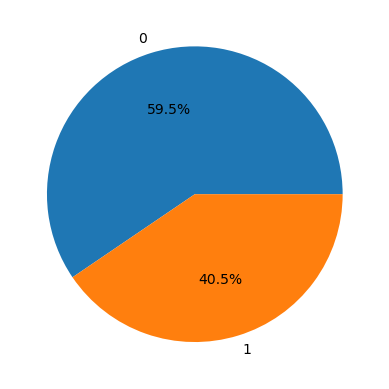

In [9]:
fig, ax = plt.subplots()
df = train_labels['label'].value_counts().reset_index()
df
ax.pie(df['count'], labels=df['label'], autopct='%1.1f%%')

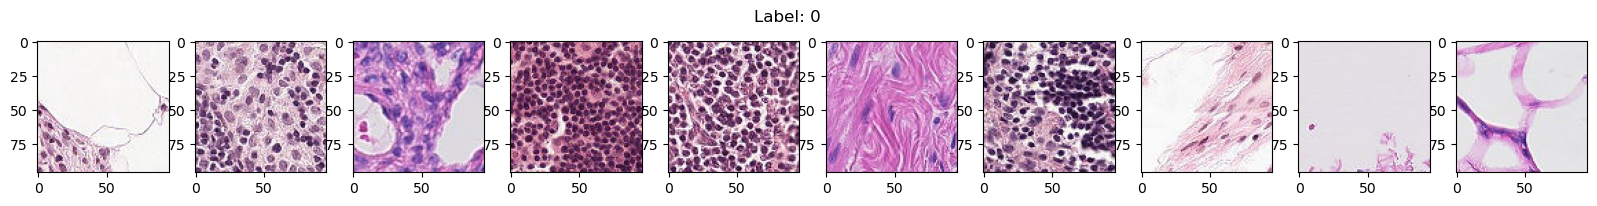

In [10]:
# data is reasonably split between positive (1) and negative (0) tests for cancer
# Lets see some sample images that do not have cancer

n = 10
label = 0
fig, ax = plt.subplots(1,n,figsize=(20,2))
df = train_labels[train_labels['label']==label].head(n)['path'].values
for i in range(len(df)):
    im = Image.open(path_train+df[i])
    ax[i].imshow(im)
fig.suptitle('Label: '+str(label))
plt.show()

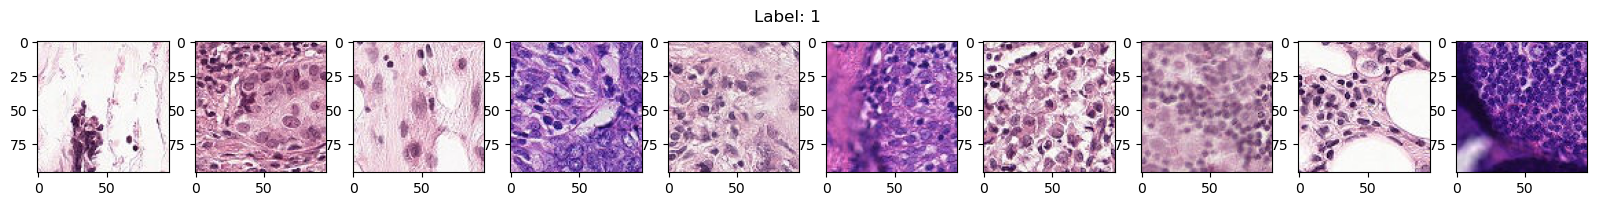

In [11]:
# Now lets see some sample images that do have cancer

n = 10
label = 1
fig, ax = plt.subplots(1,n,figsize=(20,2))
df = train_labels[train_labels['label']==label].head(n)['path'].values
for i in range(len(df)):
    im = Image.open(path_train+df[i])
    ax[i].imshow(im)
fig.suptitle('Label: '+str(label))
plt.show()

In [12]:
# batch size impacts running time, larger batches are faster to run, but lose some data recall and precision

# if we take a subset of the data (i.e. 5,000 to 10,000 rows, for example) we would significantly increase processing speed at the cost of loss
# of some information

# one of the most important model design decisions is how much of the dataset to use.  If we use the entire dtaaset of 220,024 images, we maximize our 
# information at a large cost of processing speed.  On the other hand, a subset of the data is much faster but we lose information.
# I chose to eventually use the full dataset, but I first experimented with smaller datasets (500, low thousands) before using the full dataset.
# for faster testing and development, using a subset of the full dataset is ideal.  

train_labels['label_s'] = train_labels['label'].apply(lambda x: str(x))

batch_size = 200
# data_gen = ImageDataGenerator(rescale=1/255, validation_split approximately 0.15, 33,004 validation)
# 0 to 187,020 for training; 187020 to 220024 for validation
# [0:187020]  [187020:220224]
data_gen = ImageDataGenerator(rescale=1/255)
training = data_gen.flow_from_dataframe(
    dataframe = train_labels.iloc[0:187020],
    directory = path_train,
    x_col = 'path',
    y_col = 'label_s',
    batch_size = batch_size,
    shuffle = False,
    class_mode = 'binary', #binary labels need to be strings
    target_size = (96,96),
#     subset = 'training',
    seed = 101,
    validate_filenames = True
)

validation = data_gen.flow_from_dataframe(
    dataframe = train_labels.iloc[187020:220224],
    directory = path_train,
    x_col = 'path',
    y_col = 'label_s',
    batch_size = batch_size,
    shuffle = False,
    class_mode = 'binary', #binary labels need to be strings
    target_size = (96,96),
#     subset = 'validation',
    seed = 101,
    validate_filenames = True
)

Found 187020 validated image filenames belonging to 2 classes.
Found 33005 validated image filenames belonging to 2 classes.


In [13]:
# adapted from https://www.tensorflow.org/tutorials/keras/text_classification
def plot_func(history):
    history_dict = history.history
    history_dict.keys()


    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(acc) + 1)

    # "bo" is for "blue dot"
    plt.plot(epochs, loss, 'bo', label='Training loss')
    # b is for "solid blue line"
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    plt.show()

In [14]:
#Increasing kernel sizes and pool sizes will increase processing speed, but lose some information.  I tried several# 
# different combinations of layers, kernel sizes, and pool sizes

In [15]:
my_model = tf.keras.Sequential([
    layers.Conv2D(64, kernel_size=(3,3), padding='same', activation='relu', input_shape=(96,96,3)),
    layers.MaxPooling2D(pool_size=(2,2), strides=2, padding='same'),
    layers.Conv2D(32, kernel_size=(3,3), padding='same', activation='relu', input_shape=(96,96,3)),
    layers.MaxPooling2D(pool_size=(2,2), strides=2, padding='same'),
    layers.Conv2D(16, kernel_size=(3,3), padding='same', activation='relu', input_shape=(96,96,3)),
    layers.MaxPooling2D(pool_size=(2,2), strides=2, padding='same'),
    layers.Flatten(),
    layers.Dense(8, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
my_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'], optimizer=tf.optimizers.Adam(learning_rate=0.0001))
my_model.summary()

C:\Users\thoma\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 96, 96, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │        18,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,329 (169.25 KB)

 Trainable params: 43,329 (169.25 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
history = my_model.fit(x=training, validation_data=validation, epochs=6)

C:\Users\thoma\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/6
936/936 ━━━━━━━━━━━━━━━━━━━━ 322s 343ms/step - accuracy: 0.7096 - loss: 0.5545 - val_accuracy: 0.7957 - val_loss: 0.4491
Epoch 2/6
936/936 ━━━━━━━━━━━━━━━━━━━━ 304s 325ms/step - accuracy: 0.7962 - loss: 0.4497 - val_accuracy: 0.7958 - val_loss: 0.4471
Epoch 3/6
936/936 ━━━━━━━━━━━━━━━━━━━━ 305s 326ms/step - accuracy: 0.8048 - loss: 0.4329 - val_accuracy: 0.8042 - val_loss: 0.4306
Epoch 4/6
936/936 ━━━━━━━━━━━━━━━━━━━━ 315s 337ms/step - accuracy: 0.8102 - loss: 0.4220 - val_accuracy: 0.8168 - val_loss: 0.4080
Epoch 5/6
936/936 ━━━━━━━━━━━━━━━━━━━━ 348s 372ms/step - accuracy: 0.8163 - loss: 0.4111 - val_accuracy: 0.8126 - val_loss: 0.4124
Epoch 6/6
936/936 ━━━━━━━━━━━━━━━━━━━━ 380s 406ms/step - accuracy: 0.8237 - loss: 0.3982 - val_accuracy: 0.8261 - val_loss: 0.3987


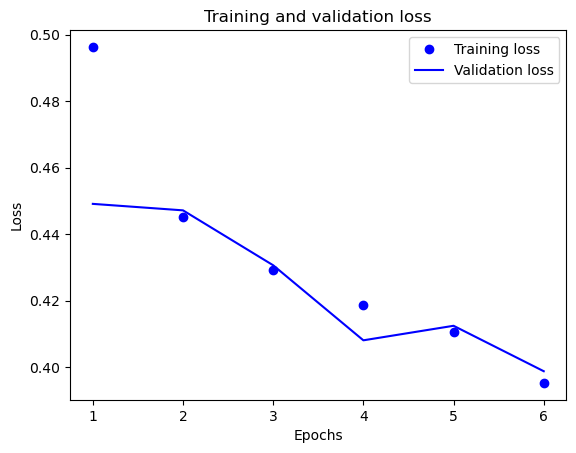

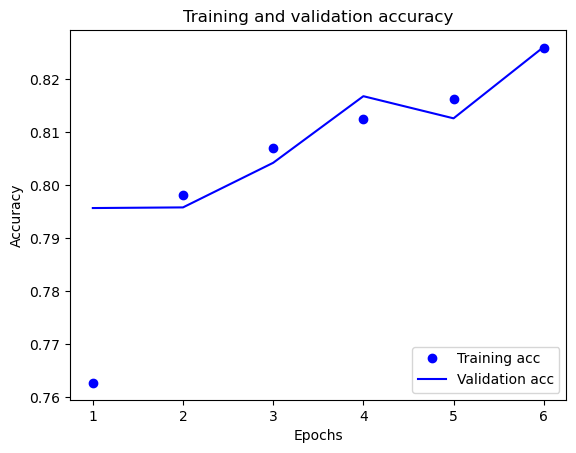

In [17]:
plot_func(history)

In [18]:
val_pred = my_model.predict(validation)
val_pred

166/166 ━━━━━━━━━━━━━━━━━━━━ 32s 192ms/step


array([[0.40036798],
       [0.28861505],
       [0.9619473 ],
       ...,
       [0.09496994],
       [0.18619879],
       [0.08081552]], dtype=float32)

In [19]:
# val_y_batch = [int(i) for i in val_y_batch]
val_pred = val_pred.reshape(1,-1)[0]
val_pred[val_pred >= 0.5] = '1'
val_pred[val_pred < 0.5] = '0'
print('Lengths:', len(val_pred), len(train_labels.iloc[187020:220224]['label_s'].values))
val_pred

Lengths: 33005 33005


array([0., 0., 1., ..., 0., 0., 0.], dtype=float32)

Accuracy: 0.83
F1: 0.76
Precision: 0.87
Recall: 0.67


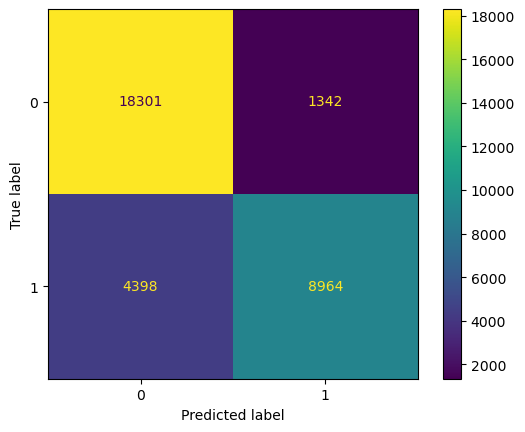

In [20]:
val_label = train_labels.iloc[187020:220224]['label'].values
cm = confusion_matrix(val_label, val_pred)
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()
print('Accuracy: %.2f' %(accuracy_score(val_label, val_pred)))
print('F1: %.2f' %(f1_score(val_label, val_pred)))
print('Precision: %.2f' %(precision_score(val_label, val_pred)))
print('Recall: %.2f' %(recall_score(val_label, val_pred)))

In [21]:
# Based on the confusion matrix results above, the model does reasonably well

test_df = pd.DataFrame(images_test, columns=['path'])
test_df['id'] = test_df['path'].apply(lambda x: x.replace('.tif',''))
test = data_gen.flow_from_dataframe(
    dataframe = test_df,
    directory = path_test,
    x_col = 'path',
    shuffle = False,
    target_size = (96,96),
    class_mode=None, #testing df
    classes=None,
    validate_filenames = True
)

Found 57458 validated image filenames.


In [22]:
test_pred = my_model.predict(test)

   1/1796 ━━━━━━━━━━━━━━━━━━━━ 3:24 114ms/step

C:\Users\thoma\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1796/1796 ━━━━━━━━━━━━━━━━━━━━ 53s 30ms/step


In [23]:
test_pred = test_pred.reshape(1,-1)[0]
test_pred[test_pred >= 0.5] = '1'
test_pred[test_pred < 0.5] = '0'
print('Lengths:', len(test_pred), len(test_df))

test_df['label'] = test_pred
test_df['label'] = test_df['label'].astype(int)
test_df[['id','label']]

test_df[['id','label']].to_csv('submission.csv', index=False)



Lengths: 57458 57458
